# Group E Assignment 5: NILMTK

## Exercise 1

### Load UKDALE data into memory and print out the metadata

In [2]:
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.timeframe import TimeFrame
import pandas as pd

ukdale = DataSet('./data/ukdale.h5')


#train = DataSet('/path/redd.h5')

### 1.2 Print out Metadata

In [3]:
print_dict(ukdale.metadata)

### Print out Buildings

In [4]:
print_dict(ukdale.buildings)

### 1.3 Print out the sub-metered appliances in each building

In [ ]:
for build in ukdale.buildings:
    print("Appliances of Building " +str(build))
    print(ukdale.buildings[build].elec.submeters())
    print("---")

In [ ]:
elec = ukdale.buildings[1].elec

### 1.4 Calculate the total energy consumption for building 1 in kWh

In [ ]:
elec.mains().total_energy()

### 1.5 Print out the type of power for mains and sub-meters

In [ ]:
elec.mains().available_ac_types('power')

In [ ]:
elec.submeters().available_ac_types('power')

## Exercise 2

### 2.1 Timeframed "Fridge Freezer" and "Light" Power Plot

In [ ]:
ukdale_window = DataSet('./data/ukdale.h5')
ukdale_window.set_window(start='2014-04-28', end='2014-04-29')

fridge_meter = ukdale_window.buildings[1].elec['fridge freezer']
light_meter = ukdale_window.buildings[1].elec['light']
elec = ukdale_window.buildings[1].elec

In [ ]:
fridge_meter.plot()
light_meter.plot()

### 2.2 Plot Overall Consumption For that time period

In [ ]:
all_window = next(ukdale_window.buildings[1].elec.load())
all_window.head()

In [ ]:
all_window['power'].plot()

### 2.3 Calculate and plot the energy consumption fraction for each sub-meter

In [ ]:
energy_fraction_per_submeter = elec.submeters().energy_per_meter().transpose().fillna(0)
del energy_fraction_per_submeter['reactive']
active_en = energy_fraction_per_submeter['active']
active_en_frac = active_en/active_en.sum()
active_en_frac.plot(kind="bar", figsize=(15,10), title="Active Energy Fraction")

In [ ]:
apparent_en = energy_fraction_per_submeter['apparent']
apparent_en_frac = apparent_en/apparent_en.sum()
apparent_en_frac.plot(kind="bar", figsize=(15,10), title="Apparent Energy Fraction")

### 2.4 Find appliances of the type “single-phase induction motor”

In [ ]:
elec.select_using_appliances(category='single-phase induction motor')

## Exercise 3

In [5]:
import time
import pandas as pd
from six import iteritems
import matplotlib.pyplot as plt
import numpy as np

train = DataSet('./data/ukdale.h5')
test = DataSet('./data/ukdale.h5')

In [6]:
train.set_window(end="24-3-2013")
test.set_window(start="25-3-2013")

train_elec = train.buildings[3].elec
test_elec = test.buildings[3].elec

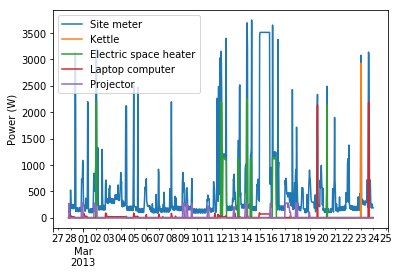

In [7]:
train_elec.plot()

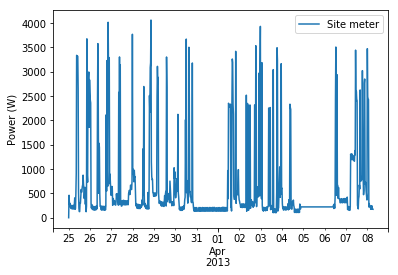

In [8]:
test_elec.mains().plot()

In [9]:
mains = train_elec.mains()
mains_df = next(mains.load())
mains_df.head()

physical_quantity,power
type,apparent
2013-02-27 20:35:14+00:00,5.0
2013-02-27 20:35:20+00:00,4.0
2013-02-27 20:35:26+00:00,5.0
2013-02-27 20:35:32+00:00,5.0
2013-02-27 20:35:38+00:00,4.0


### Combinatorial Optimisation

In [ ]:
start = time.time()
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.tests.testingtools import data_dir

co = CombinatorialOptimisation()
co.train(train_elec)
end = time.time()
print("Train runtime =", end-start, "seconds.")

In [ ]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load()):
    chunk_drop_na = chunk.dropna()
    pred[i] = co.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = next(meter.load())
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i])}, index=next(iter(gt[i].values())).index).dropna()
    
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

gt_overall = gt_overall[pred_overall.columns]

gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

local_timezone = train.metadata['timezone']

common_index_local = common_index_utc.tz_convert(local_timezone)

gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

gt_overall.head()

appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

pred_overall.head()

pred_overall.head(1000).plot(label="Pred")
gt_overall.head(1000).plot(label="GT")
plt.legend()

from sklearn.metrics import mean_squared_error

rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))
    
pd.Series(rms_error)

### FHMM

In [10]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()

fhmm.train(train_elec)
end = time.time()
print("Runtime =", end-start, "seconds.")

/Users/hardanimaulana/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Training model for submeter 'ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'


/Users/hardanimaulana/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Training model for submeter 'ElecMeter(instance=3, building=3, dataset='UK-DALE', appliances=[Appliance(type='electric space heater', instance=1)])'


/Users/hardanimaulana/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Training model for submeter 'ElecMeter(instance=4, building=3, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])'


/Users/hardanimaulana/anaconda2/envs/nilmtk-env/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Training model for submeter 'ElecMeter(instance=5, building=3, dataset='UK-DALE', appliances=[Appliance(type='projector', instance=1)])'
Runtime = 27.497923851013184 seconds.


Electric space heater    486.526688
Kettle                   489.927382
Laptop computer          489.861988
Projector                195.479302
dtype: float64

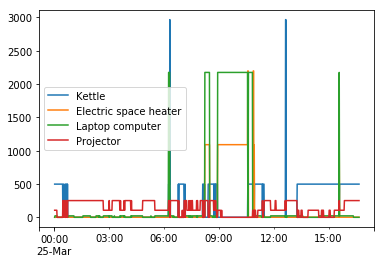

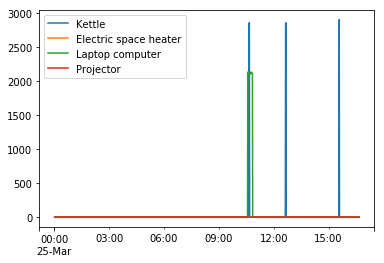

In [11]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = next(meter.load(sample_period=60))
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i])}, index=next(iter(gt[i].values())).index).dropna()
    
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

gt_overall = gt_overall[pred_overall.columns]

gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

local_timezone = train.metadata['timezone']

common_index_local = common_index_utc.tz_convert(local_timezone)

gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

gt_overall.head()

appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

pred_overall.head()

pred_overall.head(1000).plot(label="Pred")
gt_overall.head(1000).plot(label="GT")
plt.legend()

from sklearn.metrics import mean_squared_error

rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))
    
pd.Series(rms_error)

## Exercise 4

### Calculate F-Score of CO and FHMM

In [12]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from six import iteritems

warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM

In [13]:
train = DataSet('./data/ukdale.h5')
test = DataSet('./data/ukdale.h5')

In [14]:
train.set_window(end="24-3-2011")
test.set_window(start="25-3-2011")


train_elec = train.buildings[3].elec
test_elec = test.buildings[3].elec

top_5_train_elec = train_elec.submeters().select_top_k(k=5)

def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i])}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.ix[common_index_local]
    pred_overall = pred_overall.ix[common_index_local]
    appliance_labels = [m.label() for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    clf.train(top_5_train_elec, sample_period=sample_period)
    gt, predictions[clf_name] = predict(clf, test_elec, 120, train.metadata['timezone'])

4/4 ElecMeter(instance=5, building=3, dataset='UK-DALE', appliances=[Appliance(type='projector', instance=1)])e=1)])e=1)])********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=3, dataset='UK-DALE', appliances=[Appliance(type='projector', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=3, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=3, dataset='UK-DALE', appliances=[Appliance(type='electric space heater', instance=1)])'
Done training!
Estimating power demand for 'ElecMeter(instance=5, building=3, dataset='UK-DALE', appliances=[Appliance(type='projector', instance=1)])'
Estimating power demand for 'ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle',

IndexError: list index out of range

In [ ]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)

In [ ]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = compute_rmse(gt, predictions[clf_name])
rmse = pd.DataFrame(rmse)

In [ ]:
rmse